# Gaussian Process analysis for astronomical data
Author: Leonardo Bravo

# Loading libraries

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro

# Gaussian process regression for astronomical data

Consider the following data

<IPython.core.display.Javascript object>


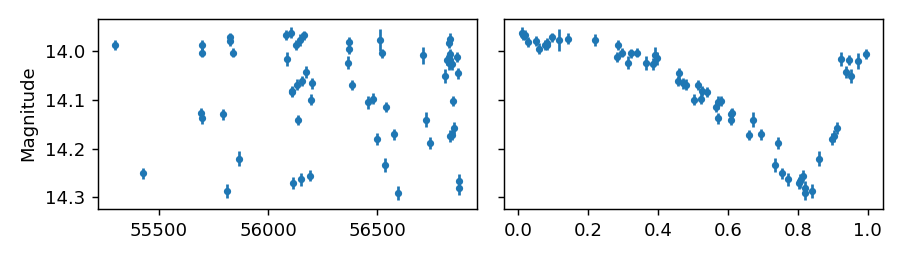

(62,)


In [5]:
lc_data = np.loadtxt('./data/rrl.dat').astype('float32')
time, mag, err, flag = lc_data.T
fig, ax = plt.subplots(1, 2, figsize=(7, 2), tight_layout=True, sharey=True)
ax[0].errorbar(time, mag, err, fmt='.');
P = 0.51194099999999998
phi = np.mod(time, P)/P
ax[1].errorbar(phi, mag, err, fmt='.');
ax[0].invert_yaxis()
ax[0].set_ylabel('Magnitude');

print(time.shape)

This is called a **light curve**: a time series of stellar brightness

This particular light curve corresponds to an RR Lyrae star

These stars pulsate regularly. The period of this one is 0.512 days

The plot on the left is actual light curve. The plot on the right is phase diagram

The phase diagram is obtained by "folding" the light curve with its given period

> The phase diagram shows the behavior of the star over one cycle

# Activity

# GP with folded light curve

Perform a Gaussian process regression over the folded light curve

- Select an appropiate kernel (or kernels) and priors for the parameters
- Fit the model and predict on `torch.linspace(0, 1, 100)`
- Sample 10 folded light curves from the GP and plot them

## Data to tensor torch

In [151]:
from sklearn.preprocessing import normalize

# data to torch tensor
time_torch = torch.from_numpy(time.astype("float32"))
phi_torch = torch.from_numpy(phi.astype("float32"))
brightness_torch = torch.from_numpy(mag.astype("float32"))
brightness_torch_norm = torch.from_numpy(normalize(mag.reshape(1, -1)).astype("float32"))

## Defining model and training model

<IPython.core.display.Javascript object>


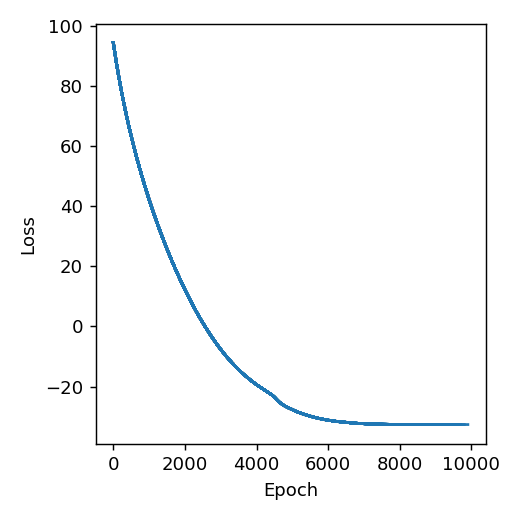

In [9]:
import pyro 
import pyro.contrib.gp as gp
from tqdm import tqdm_notebook
from pyro.distributions import LogNormal


pyro.clear_param_store()

# kernel
kernel_1 = gp.kernels.Matern52(input_dim = 1,
                            variance = torch.tensor(1.0),
                            lengthscale = torch.tensor(1.)
                              )

# kernel_2 = gp.kernels.RBF(input_dim = 1,
#                             variance = torch.tensor(1.0),
#                             lengthscale = torch.tensor(0.1)
#                               )
# combining kernels
kernel = kernel_1
# kernel = gp.kernels.Product(kernel_1, kernel_2)

# model
gpr_model = gp.models.GPRegression(phi_torch,
                                  brightness_torch,
                                  kernel = kernel,
#                                   jitter = 1e-6,
                                   jitter = 1e-2,
                                  noise = torch.tensor(1.)
                                  )

# priors to covariance parameters
gpr_model.kernel.lengthscale = pyro.nn.PyroSample(LogNormal(0., 1.0))
gpr_model.kernel.variance = pyro.nn.PyroSample(LogNormal(0., 1.0))
gpr_model.noise = pyro.nn.PyroSample(LogNormal(0., 1.0))

# optimizer 
optimizer = torch.optim.Adam(gpr_model.parameters(), lr = 1e-3)

# criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss

# training
num_epochs = 10000
fig, ax = plt.subplots(figsize = (4,4), tight_layout = True)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# epoch array
epoch_loss = np.zeros((num_epochs,))

# training by epochs
for epoch in tqdm_notebook(range(num_epochs)):
    
    # to zero all gradients
    optimizer.zero_grad()
    
    # getting loss value
    loss = criterion(gpr_model.model, gpr_model.guide)
    
    # get gradient
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # store epoch
    epoch_loss[epoch] = loss
#     print("iter {0}: {1}".format(epoch, loss))

    # plot errors
    if epoch % 100 == 0:
        
        ax.plot(range(epoch), epoch_loss[0:epoch], c = "tab:blue")
        fig.canvas.draw()

### Comentarios
Se observa que error de training disminuye y se mantiene estable. Se podría mejorar el entrenamiento haciendo un split sobre los datos (en testing y training) y luego, durante el entrenamiento, analizar el error de testing, aplicando early stopping para detener al detectar overfitting. 

Se prueban varios kernels, y finalmente se escoge el que esta en el código.

In [18]:
# Learned parameters
display("Covariance variance: ", gpr_model.kernel.variance.item())
display("covariance lengthscale: ", gpr_model.kernel.lengthscale.item())
display("model noise: ", gpr_model.noise.item())

'Covariance variance: '

0.432851642370224

'covariance lengthscale: '

1.2144309282302856

'model noise: '

1.5328456163406372

### Comentarios
Se tienen variance, lenghtscale y noise con valores positivos, debido al prior que se define. Adicionalmente, los valores son pequeños. Esto debido a que los parámetros del prior se escogieron como 0 para loc y 1 para scale.

data:  (62,)
mu:  torch.Size([100])
cov:  torch.Size([100, 100])


<IPython.core.display.Javascript object>


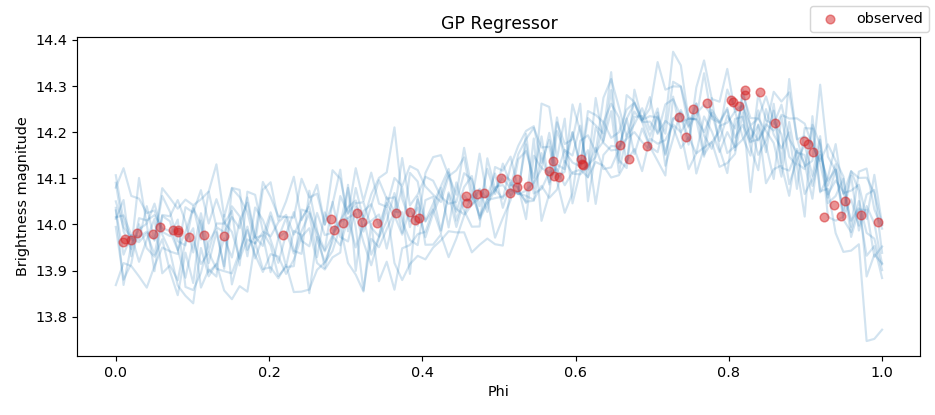

torch.Size([62])


In [52]:
# Plotting results
# time_for_predict = torch.linspace(0, 1, 10) # this is working
time_for_predict = torch.linspace(0, 1, 100) # this is working
# time_for_predict = time_torch

# print(time_for_predict.shape)
# mu, cov = gpr_model.forward(torch.from_numpy(phi.astype('float32')), full_cov=True, noiseless=True)
# mu, cov = gpr_model.forward(time_for_predict, full_cov=True, noiseless=True) # this is working
mu, cov = gpr_model.forward(time_for_predict, full_cov=True, noiseless = False) 


print("data: ", phi.shape)
print("mu: ", mu.shape)
print("cov: ", cov.shape)

# sampling
sampling = pyro.distributions.MultivariateNormal(mu, covariance_matrix = cov).sample(sample_shape = (10, ))
# print(sampling.shape)
# plotting
fig, ax = plt.subplots(figsize = (9,4), tight_layout = True)
ax.set_xlabel("Phi")
ax.set_ylabel("Brightness magnitude")
ax.set_title("GP Regressor")

for i in range(sampling.shape[0]):
    
#     print(time_for_predict.shape)
#     print(sampling[i, :].reshape(-1).shape)
    ax.plot(time_for_predict, sampling[i, :].reshape(-1), c = "tab:blue", alpha = 0.2)
#     ax.scatter(x_s, sampling[i, :], c = "red", alpha = 0.3)

print(brightness_torch.shape)
ax.scatter(phi_torch, brightness_torch, c = "tab:red", label = "observed", zorder = 10, alpha = 0.5)

# ax.scatter(time_for_predict, brightness_torch, label = "observed", linewidth = 10, c = "black", zorder = 10)
# # ax.plot(x_s, f(x_s), c = "tab:red", label = "true function")
fig.legend(loc = 1)

### Comentarios
Se observa como las curvas generadas (azules) modelan los datos observados (rojos). Se destaca que el modelo logra modelar la curva períodica enrollada, logrando incluso modelar al zona curva cerca de un valor de phi de 0.8. 

Además, se observa que cada curva es diferente de las demás, esto dado la naturaleza del modelo, en donde cada curva se obtiene un muestreo desde la gaussiana multivariada (con los parámetros obtenidos a partir de los datos a predecir (phi) y del modelo entrenado). 

# GP with raw light curve
Perform a Gaussian process regression over the actual light curve
- Use a periodic kernel and fix the period to the known value
- Fit the model and predict on `torch.linspace(55500, 57000, 100)`
- Sample 10 light curves from the GP and plot them folded over the period

### Comentarios
En el modelo se utiliza kenrel periodico, con período definido en inicio de notebook. Debido a que se intenta fijar su valor (y que no cambie), se agregar requires_grad, sin embargo no se tienen buenos resultados.

Se prueban varias configuraciones de kernel, diferentes valores de parámetros del kernel períodico (variance, lenghtscale), diferentes kernels (Linear, Polynomial) y diferentes combinaciones de kernel (suma y producto), pero no se encuentra el kernel apropiado para poder modelar correctamente los datos (resultados mostrados al final). 

Se probaron diferentes kernels (no solo el periodico), ya que desde la data, se observa que esta tiene un comportamineto complejo, que quizás tenga componentes no períodicas (como comportamientos lineales (tendencias)). Debido a lo anterior, se intenta realizar combinaciones de kernel periodico con Linear y Polynomic, sin embargo se tenían problemas de matrices singulares (RuntimeError: cholesky_cpu: U(2,2) is zero, singular U), por lo que no podía entrenar el modelo. Buscando en diferentes recursos, se tiene que el problema quizás pueda deberse a problemas con los datos de entrenamiento, los cuales pueden estar genernadoe stos problemas numéricos.

Se probaron tambien diferentes priors, pero con ninugno se logran buenos resultados.

Se intentan diferentes combinaciones pero no se logran buenos resultados.

<IPython.core.display.Javascript object>


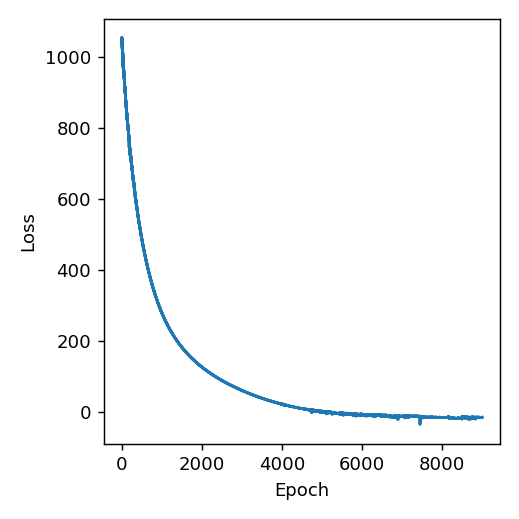

In [173]:
import pyro 
import pyro.contrib.gp as gp
from tqdm import tqdm_notebook
from pyro.distributions import LogNormal


pyro.clear_param_store()

kernel_1 = gp.kernels.Periodic(input_dim = 1,
                               variance = torch.tensor(1.0),
                               lengthscale = torch.tensor(10.),
#                                period = torch.tensor(P, requires_grad = False) # Se intenta dejar como parámetro fijo, entonces por eso se intenta agregar requires_grad False (para que no se actualize)
                               period = torch.tensor(P, requires_grad = False),
                              ) 
# kernel_2 = gp.kernels.Cosine(input_dim = 1,
#                                variance = torch.tensor(1.0),
#                                lengthscale = torch.tensor(1.0),
#                               ) 
# kernel_2 = gp.kernels.Polynomial(input_dim = 1,
#                                 variance = torch.tensor(1.0),
# #                                 degree = 3
#                                 )

# display("kernel period: ", gpr_model.kernel.period.item())
# kernel_2 = gp.kernels.Linear(input_dim=1, variance=torch.tensor(1.))
# combining kernels
kernel = kernel_1
# kernel = kernel_2
# kernel = gp.kernels.Product(kernel_1, kernel_2)
# kernel = gp.kernels.Sum(kernel_1, kernel_2)

# model
gpr_model = gp.models.GPRegression(time_torch,
                                  brightness_torch,
#                                    brightness_torch_norm,
                                  kernel = kernel,
#                                   jitter = 1e-6,
#                                   jitter = 1e-2, # this is working
#                                    jitter = 1e-1,
                                  noise = torch.tensor(1.0)
                                  )

# priors to covariance parameters
gpr_model.kernel.lengthscale = pyro.nn.PyroSample(LogNormal(0., 1.0))
# gpr_model.kernel.set_constraint('lengthscale', constraint.greater_than(0.01))
# gpr_model.kernel.set_constraint(param = "lengthscale", constraint = constraints.greaterthan(0.1))
gpr_model.kernel.variance = pyro.nn.PyroSample(LogNormal(0., 1.0))
gpr_model.noise = pyro.nn.PyroSample(LogNormal(0., 1.0))

# gpr_model.kernel.set_constraint(param = "period", constraint = )

# optimizer 
optimizer = torch.optim.Adam(gpr_model.parameters(), lr = 1e-3)

# criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss

# training
# num_epochs = 60000
num_epochs = 10000
fig, ax = plt.subplots(figsize = (4,4), tight_layout = True)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# epoch array
epoch_loss = np.zeros((num_epochs,))

# training by epochs
for epoch in tqdm_notebook(range(num_epochs)):
    
    # to zero all gradients
    optimizer.zero_grad()
    
    # getting loss value
    loss = criterion(gpr_model.model, gpr_model.guide)
    
    # get gradient
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # store epoch
    epoch_loss[epoch] = loss
#     print("iter {0}: {1}".format(epoch, loss))

    # plot errors
    if epoch % 1000 == 0:
        
        ax.plot(range(epoch), epoch_loss[0:epoch], c = "tab:blue")
        fig.canvas.draw()

### Comentarios
Se observa que loss disminuye con el número de epochs, manteniéndose estable para los últimos epochs. Se repite comentario de entrenamiento de otro modelo, en donde se podría mejorar el entrenamiento aplicando las técnicas mencionadas en el modelo anterior.

In [174]:
# Learned parameters
display("Covariance variance: ", gpr_model.kernel.variance.item())
display("covariance lengthscale: ", gpr_model.kernel.lengthscale.item())
display("model noise: ", gpr_model.noise.item())
display("kernel period: ", gpr_model.kernel.period.item())

'Covariance variance: '

0.45425352454185486

'covariance lengthscale: '

1.8481593132019043

'model noise: '

2.0624146461486816

'kernel period: '

0.5158080458641052

### Comentarios
Se observa que el período tiene un valor distinto al fijo, sin embargo desconozco si esto podría estar influyendo en los resultados. Tendería a pensar que el valor se debería mantener fijo, ya que se probó (analizando la curva de luz inicial), que la curva es sensible al valor del período, ya que al cambiar muy poco el período, ya no se observa la periodicidad de la curva. 

data:  (62,)
mu:  torch.Size([100])
cov:  torch.Size([100, 100])
sampling:  torch.Size([10, 100])


<IPython.core.display.Javascript object>


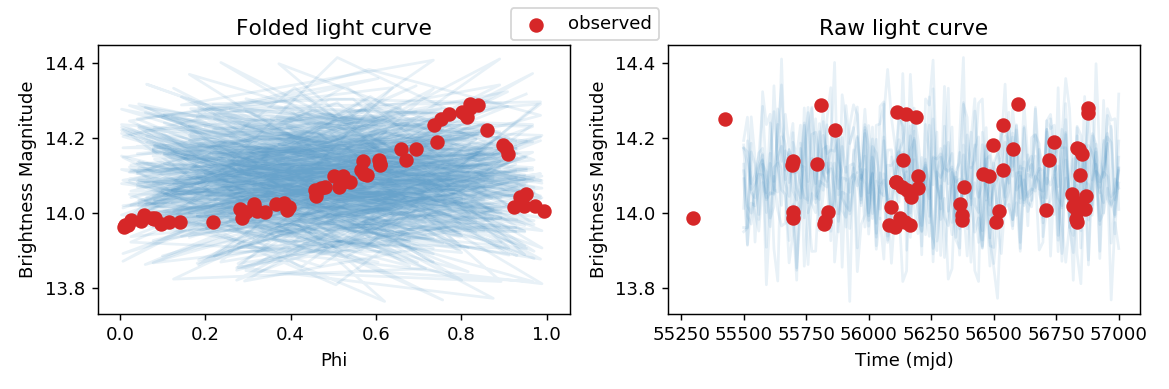

In [175]:
# Plotting results
time_for_predict = torch.linspace(55500, 57000, 100)
# time_for_predict = time_torch

# print(time_for_predict.shape)
# mu, cov = gpr_model.forward(torch.from_numpy(phi.astype('float32')), full_cov=True, noiseless=True)
mu, cov = gpr_model.forward(time_for_predict, full_cov=True, noiseless=False)

print("data: ", phi.shape)
print("mu: ", mu.shape)
print("cov: ", cov.shape)

# sampling
# We sum a small value to the diagonal for numerical stability
cov = cov + torch.eye(len(time_for_predict))*1e-4
# samlping
sampling = pyro.distributions.MultivariateNormal(mu, covariance_matrix = cov).sample(sample_shape = (10, ))
print("sampling: ", sampling.shape)

# fold light curves
# folded_time_for_predict = np.mod(time_for_predict, P)/P
# P_model = gpr_model.kernel.period.item()
P_model = P
# P_model = 0.5119444131851196
folded_time_for_predict = np.mod(time_for_predict, P_model)/P_model
# gpr_model.kernel.period.item()
# print(folded_time_for_predict.shape)

# plotting
fig, ax = plt.subplots(1, 2, figsize = (9,3), tight_layout = True)
ax[0].set_xlabel("Phi")
ax[0].set_ylabel("Brightness Magnitude")
ax[0].set_title("Folded light curve")
ax[1].set_xlabel("Time (mjd)")
ax[1].set_ylabel("Brightness Magnitude")
ax[1].set_title("Raw light curve")


for i in range(sampling.shape[0]):
#     print(i)

    # folded
    ax[0].plot(folded_time_for_predict, sampling[i, :], c = "tab:blue", alpha = 0.1)
    
    # raw data
    ax[1].plot(time_for_predict, sampling[i, :], c = "tab:blue", alpha = 0.1)
    

ax[0].scatter(phi_torch, brightness_torch, linewidth = 2, c = "tab:red", zorder = 10)
ax[1].scatter(time_torch, brightness_torch, label = "observed", linewidth = 2, c = "tab:red", zorder = 10)
# # ax.plot(x_s, f(x_s), c = "tab:red", label = "true function")
fig.legend(loc = 9)

### Comentarios
Desde  el gráfico de Folded light curve, se observa que las 10 curvas no modelan de forma corecta la curva de luz enrollada. 

Desde el gráfico de Raw light curve, es complejo concluir sobre la modelación, ya que se desconoce la curva real de los datos.

Dadas las funciones ploteadas en gráfico izquierdo, se tiene que modelo no es capaz de modelar correctamente el comportamineto de la curva. Esto se podría deber quizás a que el kernel no es el correcto para modelar los datos (tal como se explica en los comentarios del bloque anterior). Otra posible causa, es que el período de la curva no se logra fijar en el valor teórico (tal como se explica en el bloque anterior).

Quizás, una forma de obtener un kernel mas apropiado, sería intentar arreglar error de matrices singulares (tal como se explica en bloques anteriores). 

Quizás tambien se podrían seguir probando diferentes combinaciones de kernels, y analizar si alguna logra buenos resultados.

# Conclusiones
- Se logra implementar GP Regressor para curva de luz.
- Se logra modelar correctamente la curva de luz utilizando GP Regressor entrenado el modelo con la curva de luz enrollada. 
- No se logra modelar correctamente la curva de luz entrenando el modelo con la curva de luz directa (sin enrollar) y utiliznado kernel períodico.
- Se utilizan diferentes combinaciones de kernel para entrenar curva de luz utilizando data bruta, pero con ninguna se lgoran buenos resultados.
- Es relevante recalcar que el modelo no asume una estructura fija (tal como lo haría un modelo por ejemplo, de regresion), lo que genera mayor flexibilidad en la modelación.